# 📘 Online Retail II 数据集建模与仿真
## 使用随机过程进行客户行为建模

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from lifelines import CoxPHFitter, KaplanMeierFitter
from collections import defaultdict
import random
from sklearn.preprocessing import KBinsDiscretizer
import gym
from gym import Env
from gym.spaces import Discrete, Box
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3 import PPO, DQN
import warnings

warnings.filterwarnings('ignore')

## 📥 加载和清洗数据

In [2]:
df = pd.read_csv('online_retail_II.csv')
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [3]:


# 清洗数据
df = df[df['Invoice'].astype(str).str.contains('C') == False]  # 去掉取消订单
df = df[df['Quantity'] > 0]  # 只保留正数量商品
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # 转为完整时间类型（含时分秒）
df = df.dropna(subset=['Customer ID'])  # 删除无客户ID记录
df = df.drop_duplicates('Invoice')  # 去除重复发票号（关键修改）

df['TotalPrice'] = df['Quantity'] * df['Price']
# 排序整个数据集（便于后续分析）
df = df.sort_values('InvoiceDate').reset_index(drop=True)


In [6]:
df.describe()

,Quantity,Price,Customer ID,TotalPrice
count,36975.000000,36975.000000,36975.000000,36975.000000
mean,35.008032,8.208701,15298.058364,62.592145
std,601.390665,132.353171,1721.211549,1007.878693
min,1.000000,0.000000,12346.000000,0.000000
25%,3.000000,1.250000,13802.000000,10.140000
50%,9.000000,2.100000,15218.000000,17.400000
75%,20.000000,4.950000,16791.000000,35.800000
max,80995.000000,10953.500000,18287.000000,168469.600000


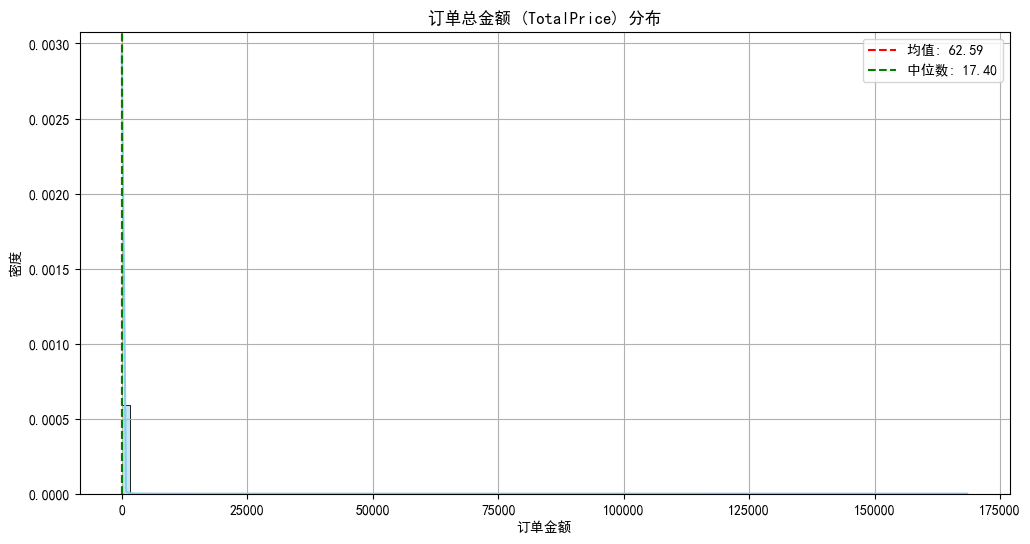


📊 TotalPrice 统计指标:
均值（Mean）: 62.59
中位数（Median）: 17.40


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 假设 df 是你已经加载的数据框，并包含 'TotalPrice' 列
# 示例：df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# ---------- 1. 查看 TotalPrice 分布 ----------
plt.figure(figsize=(12, 6))

# 直方图 + KDE 密度曲线
sns.histplot(df['TotalPrice'], bins=100, kde=True, color='skyblue', stat="density")

# 添加均值和中位数竖线
mean_val = df['TotalPrice'].mean()
median_val = df['TotalPrice'].median()

plt.axvline(mean_val, color='red', linestyle='--', label=f'均值: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', label=f'中位数: {median_val:.2f}')

plt.title("订单总金额 (TotalPrice) 分布")
plt.xlabel("订单金额")
plt.ylabel("密度")
plt.legend()
plt.grid(True)
plt.show()

# ---------- 2. 输出两个科学指标 ----------
print("\n📊 TotalPrice 统计指标:")
print(f"均值（Mean）: {mean_val:.2f}")
print(f"中位数（Median）: {median_val:.2f}")

In [5]:
# 计算两个分位点（33%, 66%）
# 按 TotalPrice 从高到低排序并显示
sorted_df = df[['InvoiceDate', 'Customer ID', 'TotalPrice']].sort_values(by='TotalPrice', ascending=False)

# 显示前 20 行
print("\n📈 TotalPrice 从高到低排序（前20条）:")
print(sorted_df.head(20))
q1 = df['TotalPrice'].quantile(0.33)
q2 = df['TotalPrice'].quantile(0.66)

print(f"\n📊 分位数阈值:")
print(f"33% 分位: {q1:.2f}")
print(f"66% 分位: {q2:.2f}")
# 统计 TotalPrice > 1000 的订单数量
count = df[df['TotalPrice'] > 0].shape[0]

print(f"\n🛒 TotalPrice > 1000 的订单数量: {count} 单")


📈 TotalPrice 从高到低排序（前20条）:
                InvoiceDate  Customer ID  TotalPrice
1065882 2011-12-09 09:15:00      16446.0   168469.60
587080  2011-01-18 10:01:00      12346.0    77183.60
748132  2011-06-10 15:28:00      15098.0    38970.00
432176  2010-11-04 11:36:00      15838.0    15818.40
135013  2010-03-23 15:22:00      12918.0    10953.50
358639  2010-09-27 16:12:00      14063.0    10468.80
74356   2010-01-29 11:04:00      17949.0     8985.60
228042  2010-06-08 12:59:00      18008.0     8925.00
698843  2011-05-03 13:46:00      16029.0     8142.75
873786  2011-09-20 11:05:00      17450.0     7144.72
129903  2010-03-19 11:35:00      15760.0     6958.17
129987  2010-03-19 11:45:00      15760.0     6958.17
686007  2011-04-18 13:20:00      15749.0     6539.40
578172  2011-01-11 12:55:00      15749.0     6539.40
379875  2010-10-08 10:10:00      15838.0     5179.20
947062  2011-10-27 12:11:00      14646.0     4992.00
578170  2011-01-11 12:55:00      15749.0     4921.50
686003  2011-04-18

## 🎲 随机过程模型：泊松过程模拟订单到达


共分析了 604 天
其中符合泊松过程的天数: 492 天 (81.46%)
不符合的天数: 112 天


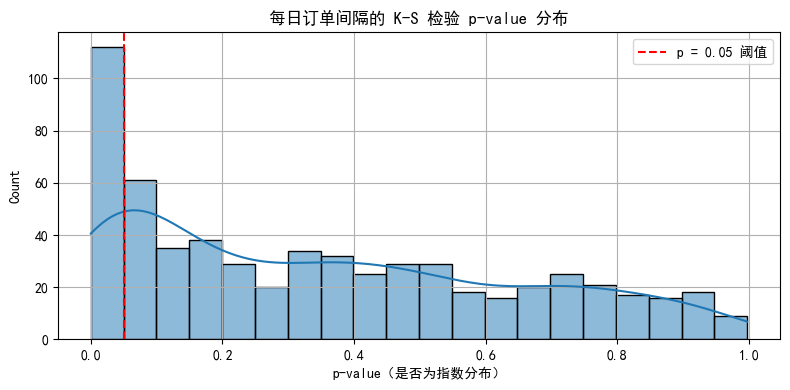

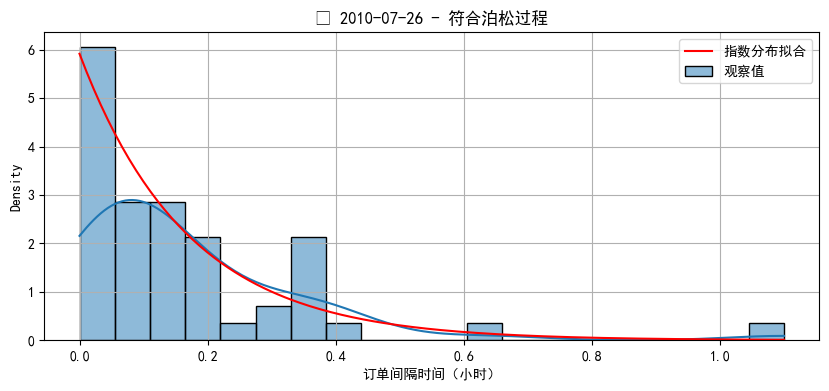

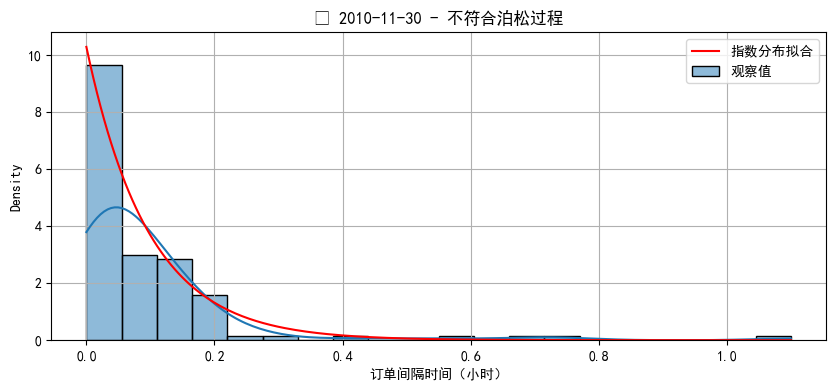

In [6]:
# ---------------------
# 二、按日期（每天）分析泊松过程（使用完整时间戳：时分秒）
# ---------------------
from scipy.stats import expon, kstest
# 设置索引为 InvoiceDate 并按天分组
daily_groups = df.set_index('InvoiceDate').groupby(pd.Grouper(freq='D'))

daily_intervals = {}  # 存储每天的订单间隔时间

for date, group in daily_groups:
    if len(group) < 2:
        continue  # 至少需要两个订单才能计算间隔

    times = group.index  # 获取该天所有订单的完整时间戳（含时分秒）
    times_sorted = sorted(times)  # 确保时间顺序正确

    # 计算相邻订单的时间间隔（转换为小时）
    intervals = [(t2 - t1).total_seconds() for t2, t1 in zip(times_sorted[1:], times_sorted[:-1])]
    intervals_in_hours = [sec / 3600 for sec in intervals]  # 转换为小时

    daily_intervals[date.date()] = intervals_in_hours  # 保存每天的间隔

# ---------------------
# 检验函数：某一天是否符合泊松过程
# ---------------------
def test_day_poisson(intervals):
    mean_interval = np.mean(intervals)
    D_stat, p_value = kstest(intervals, 'expon', args=(0, mean_interval))
    return {
        'date': None,
        'mean_interval': mean_interval,
        'KS_D': D_stat,
        'KS_p': p_value,
        'poisson_fit': p_value > 0.05
    }

# ---------------------
# 遍历所有日期，执行检验
# ---------------------
day_results = []

for date, intervals in daily_intervals.items():
    result = test_day_poisson(intervals)
    result['date'] = date
    day_results.append(result)

result_day_df = pd.DataFrame(day_results)

# ---------------------
# 输出统计信息
# ---------------------
total_days = len(result_day_df)
fit_days = result_day_df['poisson_fit'].sum()
print(f"\n共分析了 {total_days} 天")
print(f"其中符合泊松过程的天数: {fit_days} 天 ({fit_days / total_days * 100:.2f}%)")
print(f"不符合的天数: {total_days - fit_days} 天")

# ---------------------
# 可视化每日的 K-S p-value 分布
# ---------------------
plt.figure(figsize=(8, 4))
sns.histplot(result_day_df["KS_p"], bins=20, kde=True)
plt.axvline(0.05, color='red', linestyle='--', label='p = 0.05 阈值')
plt.title("每日订单间隔的 K-S 检验 p-value 分布")
plt.xlabel("p-value（是否为指数分布）")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------
# 展示一个拟合良好和一个拟合不佳的日期
# ---------------------
def plot_daily_intervals(date, intervals, mean_interval, title=""):
    x = np.linspace(0, max(intervals), 200)
    plt.figure(figsize=(10,4))
    sns.histplot(intervals, bins=20, kde=True, stat="density", label="观察值")
    plt.plot(x, expon.pdf(x, scale=mean_interval), color='red', label='指数分布拟合')
    plt.title(title)
    plt.xlabel("订单间隔时间（小时）")
    plt.legend()
    plt.grid(True)
    plt.show()

if not result_day_df.empty:
    good_days = result_day_df[result_day_df['poisson_fit']]
    bad_days = result_day_df[~result_day_df['poisson_fit']]
    if not good_days.empty and not bad_days.empty:
        sample_good = good_days.sample(1).iloc[0]
        sample_bad = bad_days.sample(1).iloc[0]

        plot_daily_intervals(
            sample_good['date'],
            daily_intervals[sample_good['date']],
            sample_good['mean_interval'],
            title=f"✅ {sample_good['date']} - 符合泊松过程"
        )

        plot_daily_intervals(
            sample_bad['date'],
            daily_intervals[sample_bad['date']],
            sample_bad['mean_interval'],
            title=f"❌ {sample_bad['date']} - 不符合泊松过程"
        )
    else:
        print("⚠️ 没有找到符合或不符合条件的样本日期。")

分析顾客: 100%|██████████| 5881/5881 [00:05<00:00, 1155.27it/s]



共分析顾客数: 971
符合泊松过程假设的顾客: 789 (81.26%)


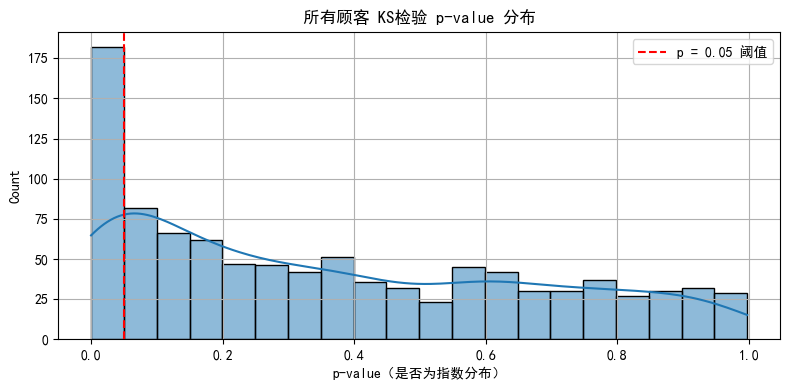

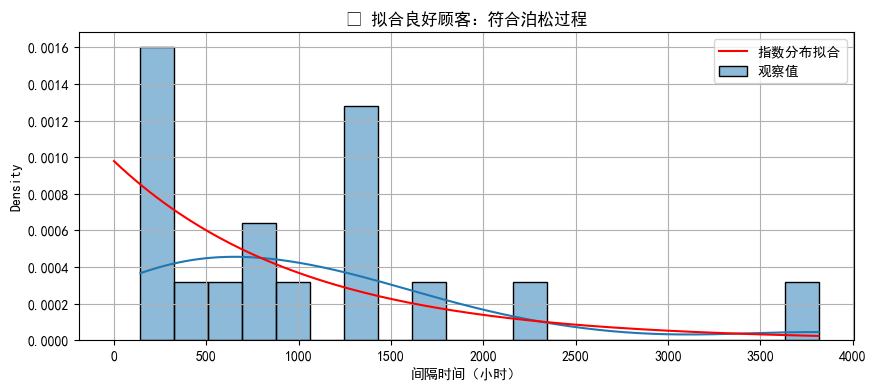

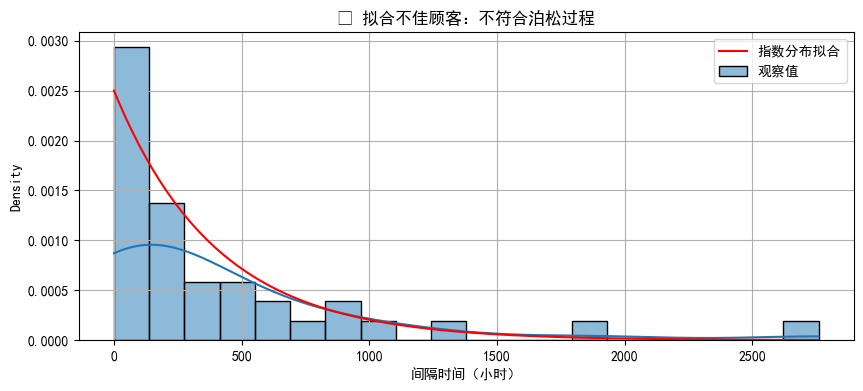

In [7]:
from scipy.stats import expon, kstest
from tqdm import tqdm
# ---------- 分析函数 ----------
def test_customer_poisson(customer_id, min_orders=10):
    cust_df = df[df["Customer ID"] == customer_id].sort_values("InvoiceDate")
    invoice_times = cust_df["InvoiceDate"].drop_duplicates().sort_values()

    if len(invoice_times) < min_orders:
        return None  # 跳过订单不足的顾客

    inter_arrival_times = invoice_times.diff().dropna().dt.total_seconds() / 3600  # 单位：小时
    mean_interval = inter_arrival_times.mean()

    D_stat, p_value = kstest(inter_arrival_times, 'expon', args=(0, mean_interval))
    return {
        'Customer ID': customer_id,
        'Orders': len(invoice_times),
        'Mean Interval (hr)': mean_interval,
        'KS D': D_stat,
        'KS p-value': p_value,
        'Poisson_fit': p_value > 0.05
    }

# ---------- 遍历所有顾客 ----------
results = []
customer_ids = df["Customer ID"].unique()

for cid in tqdm(customer_ids, desc="分析顾客"):
    result = test_customer_poisson(cid)
    if result:
        results.append(result)

result_df = pd.DataFrame(results)

# ---------- 结果汇总 ----------
total_tested = len(result_df)
poisson_like = result_df['Poisson_fit'].sum()
print(f"\n共分析顾客数: {total_tested}")
print(f"符合泊松过程假设的顾客: {poisson_like} ({100 * poisson_like / total_tested:.2f}%)")

# ---------- 可视化汇总结果 ----------
plt.figure(figsize=(8, 4))
sns.histplot(result_df["KS p-value"], bins=20, kde=True)
plt.axvline(0.05, color='red', linestyle='--', label='p = 0.05 阈值')
plt.title("所有顾客 KS检验 p-value 分布")
plt.xlabel("p-value（是否为指数分布）")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

# ---------- 示例顾客可视化 ----------
try:
    sample_good = result_df[result_df['Poisson_fit']].sample(1).iloc[0]['Customer ID']
    sample_bad = result_df[~result_df['Poisson_fit']].sample(1).iloc[0]['Customer ID']
except IndexError:
    print("⚠️ 没有找到符合或不符合条件的样本顾客，请调整 min_orders 参数或检查数据。")
else:
    def plot_customer_intervals(customer_id, title=""):
        cust_df = df[df["Customer ID"] == customer_id].sort_values("InvoiceDate")
        invoice_times = cust_df["InvoiceDate"].drop_duplicates().sort_values()
        inter_arrival_times = invoice_times.diff().dropna().dt.total_seconds() / 3600
        mean_interval = inter_arrival_times.mean()

        plt.figure(figsize=(10, 4))
        sns.histplot(inter_arrival_times, bins=20, kde=True, stat="density", label="观察值")
        x = np.linspace(0, inter_arrival_times.max(), 200)
        plt.plot(x, expon.pdf(x, scale=mean_interval), color='red', label='指数分布拟合')
        plt.title(title)
        plt.xlabel("间隔时间（小时）")
        plt.legend()
        plt.grid(True)

        plt.show()
        plt.close()

    # 展示代表性顾客拟合效果
    plot_customer_intervals(sample_good, title="✅ 拟合良好顾客：符合泊松过程")
    plot_customer_intervals(sample_bad, title="❌ 拟合不佳顾客：不符合泊松过程")

## ⏳ 点过程建模：客户购买间隔时间分析

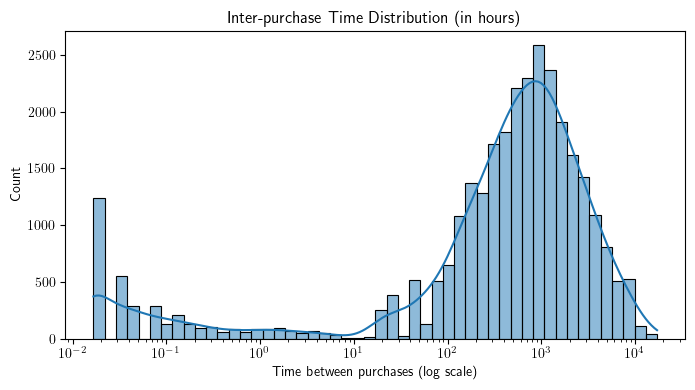

In [8]:
inter_purchase_times = []
customer_orders = df.groupby('Customer ID')['InvoiceDate'].apply(sorted).to_dict()

for cust, times in customer_orders.items():
    for i in range(1, len(times)):
        delta = (times[i] - times[i-1]).total_seconds() / 3600
        if delta > 0:
            inter_purchase_times.append(delta)
# 在绘图前添加以下设置
# 替代方案：手动替换负号字符
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(8,4))
sns.histplot(inter_purchase_times, bins=50, kde=True, log_scale=True)
plt.title("Inter-purchase Time Distribution (in hours)")
plt.xlabel("Time between purchases (log scale)")
plt.ylabel("Count")
plt.show()